In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [32]:
data = pd.read_csv('data/bank.csv', sep = ';', engine = 'python')

In [33]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Input variables:
# bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')

# related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone') 
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

# social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric) 
- cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')

In [34]:
print("Number of rows",data.size)
print("Number of columns", len(data.columns))
print("Columns")
print(data.columns)

Number of rows 76857
Number of columns 17
Columns
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')


In [35]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


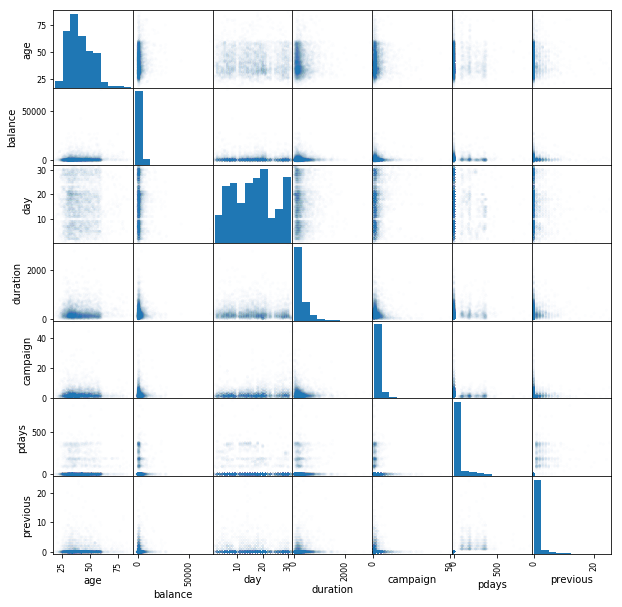

In [36]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = .01, figsize = (10, 10))
pass

Вычислим попарную корреляцию столбцов

In [37]:
data.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.083820,-0.017853,-0.002367,-0.005148,-0.008894,-0.003511
balance,0.083820,1.000000,-0.008677,-0.015950,-0.009976,0.009437,0.026196
day,-0.017853,-0.008677,1.000000,-0.024629,0.160706,-0.094352,-0.059114
duration,-0.002367,-0.015950,-0.024629,1.000000,-0.068382,0.010380,0.018080
campaign,-0.005148,-0.009976,0.160706,-0.068382,1.000000,-0.093137,-0.067833
pdays,-0.008894,0.009437,-0.094352,0.010380,-0.093137,1.000000,0.577562
previous,-0.003511,0.026196,-0.059114,0.018080,-0.067833,0.577562,1.000000


In [38]:
data.describe(include = ['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,yes,no,cellular,may,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,1398,3705,4000


Столбец poutcome практически полностью неизвестен. Возможно, имеет смысл исключить его из тренировочных данных.

### Удалим все строки, где есть пропущенные значения

Удалим стобцы, где присутствует мало значений или сами признаки, вероятно, не имеют большого смысла.

In [39]:
data = data.drop(['poutcome', 'day', 'month','duration'], axis=1)
data = data.dropna(axis = 0)

Разделим признаки на категориальные и числовые, для удобства последующей работы с ней.

In [40]:
data_describe = data.describe(include = [object])
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]

print("Categorical columns", categorical_columns)
print("Numberical columns", numerical_columns)
print("Binary columns", binary_columns)
print("Nonbinary columns", nonbinary_columns)

Categorical columns ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'y']
Numberical columns ['age', 'balance', 'campaign', 'pdays', 'previous']
Binary columns ['default', 'housing', 'loan', 'y']
Nonbinary columns ['job', 'marital', 'education', 'contact']


Переведем все бинарные признаки к одному виду.

In [41]:
for column in binary_columns:
    data.at[data[column] == 'no', column] = 0
    data.at[data[column] == 'yes', column] = 1

# Векторизируем небинарные признаки

Произведем векторизацию категориальных признаков. 
Среди присутствующих нет признаков, имеющих заведомо разную значимость. То есть все значения, внутри каждого признака, можно считать равнозначными. 

In [42]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])

Многие методы чувствительны к масштабы данных. 
Нормализуем каждый вектор признаков, чтобы разница между значениями различных признаков была не столь велика.

In [43]:
data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical.describe()

,age,balance,campaign,pdays,previous
count,4.521000e+03,4.521000e+03,4.521000e+03,4.521000e+03,4.521000e+03
mean,-1.116976e-16,1.923122e-17,6.034397e-16,-1.955721e-16,-2.665910e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.096223e+00,-1.573497e+00,-5.767657e-01,-4.071733e-01,-3.203774e-01
25%,-7.724974e-01,-4.497743e-01,-5.767657e-01,-4.071733e-01,-3.203774e-01
50%,-2.051864e-01,-3.251746e-01,-2.552023e-01,-4.071733e-01,-3.203774e-01
75%,7.403318e-01,1.905285e-02,6.636113e-02,-4.071733e-01,-3.203774e-01
max,4.333301e+00,2.318064e+01,1.517984e+01,8.302277e+00,1.444141e+01


# Соединяем все в одну таблицу

In [44]:
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)
data.describe()

(4521, 31)


,age,balance,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,default,housing,loan,y
count,4.521000e+03,4.521000e+03,4.521000e+03,4.521000e+03,4.521000e+03,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,...,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,-1.116976e-16,1.923122e-17,6.034397e-16,-1.955721e-16,-2.665910e-16,0.105729,0.209246,0.037160,0.024773,0.214333,...,0.510064,0.298607,0.041363,0.640566,0.066578,0.292856,0.016810,0.566025,0.152842,0.115240
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.307524,0.406815,0.189174,0.155451,0.410404,...,0.499954,0.457697,0.199149,0.479888,0.249318,0.455123,0.128575,0.495676,0.359875,0.319347
min,-2.096223e+00,-1.573497e+00,-5.767657e-01,-4.071733e-01,-3.203774e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.724974e-01,-4.497743e-01,-5.767657e-01,-4.071733e-01,-3.203774e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.051864e-01,-3.251746e-01,-2.552023e-01,-4.071733e-01,-3.203774e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,7.403318e-01,1.905285e-02,6.636113e-02,-4.071733e-01,-3.203774e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,4.333301e+00,2.318064e+01,1.517984e+01,8.302277e+00,1.444141e+01,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Удалим часть тестовых данных, чтобы немного уравновесить количество элементов класса

In [30]:
data = data.drop(data[:2800][data[:2800].y == 0].index)

# X и y

In [51]:
X = data.drop(('y'), axis = 1)
y = data['y']
feature_names = X.columns
N, d = X.shape

Разделим данные на тестовую и тренировочную выборки

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

3164 1357


# kNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


knn = KNeighborsClassifier(n_neighbors = 10)
knn.set_params(n_neighbors=10)
knn.fit(X_train, y_train)

y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)

print("Train error", err_train)
print("Test error", err_test)
print("Confusion matrix", confusion_matrix(y_test, y_test_predict))

Train error 0.11808031210062554
Test error 0.1266478342749529
Confusion matrix [[11004   148]
 [ 1466   126]]


# Подбор параметров

In [19]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print("Train error", err_train)
print("Test error", err_test)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\sys_avctests\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-efd06072e579>", line 5, in <module>
    grid.fit(X_train, y_train)
  File "C:\Users\sys_avctests\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 722, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\sys_avctests\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1191, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\sys_avctests\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 711, in evaluate_candidates
    cv.split(X, y, groups)))
  File "C:\Users\sys_avctests\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py", line 920, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\sys_avctests\Anaconda3\lib\site-p

KeyboardInterrupt: 

# Вывод

Подбор параметров показал, что наименьшая ошибка достигается при колчесвте соседей = 25.
Однако, стоит заметить, что отличие от результата, полученного с количеством соседей = 10, меньше 1%

# SVC

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

# Подбор параметров

In [ ]:
from sklearn.grid_search import GridSearchCV
Cs = 10.**np.arange(-5, 5)
gamma_array = 10.**np.arange(-5, 5)
svc = SVC()
grid = GridSearchCV(svc, param_grid = {'C': Cs, 'gamma': gamma_array})
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_C = grid.best_estimator_.C
print(best_cv_err, best_C)

In [ ]:
svc = SVC(C = best_C).fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

# Значимость признаков

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(d):
    print("%2d. feature '%5s' (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

In [ ]:
d_first = 20
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align = 'center', color = 'r')
plt.xticks(range(d_first), feature_names[indices[:d_first]], rotation = 90)
plt.xlim([-1, d_first])

Как видно из графика, наибольшую роль в объяснении итогового результата играют признаки balance, age, compaign, pdays, previous. Остальные признаки можно попробовать исключить т.к. степень их назимости меньше 1.5%.

# Extremely Randomized Trees

In [ ]:
ert = ensemble.ExtraTreesClassifier(n_estimators = 100).fit(X_train, y_train)

err_train = np.mean(y_train != ert.predict(X_train))
err_test  = np.mean(y_test  != ert.predict(X_test))

print(err_train, err_test)

# Ada boost

In [ ]:
ada = ensemble.AdaBoostClassifier(n_estimators = 1000)
ada.fit(X_train, y_train)

err_train = np.mean(y_train != ada.predict(X_train))
err_test = np.mean(y_test != ada.predict(X_test))

print(err_train, err_test)

# GBT

In [ ]:
gbt = ensemble.GradientBoostingClassifier(n_estimators = 1000)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test = np.mean(y_test != gbt.predict(X_test))

print(err_train, err_test)

# Neural networks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

num_layers = 4

In [ ]:
#data = pd.read_csv('data/bank.csv', sep = ';', engine = 'python')

## Проведем предобработку данных, аналогично предыдущему модулю

## Разбиваем данные на тренировочную и тестовую выборки

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(('y'), axis = 1)
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)
N_test, _ = X_test.shape

## Созданим нейронную сеть, для решения задачи классификации

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes = (num_layers,), solver = 'lbfgs', 
                          activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

In [ ]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [ ]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))

## Подбор гиперпараметров

In [ ]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (num_layers,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

In [ ]:

plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

In [ ]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

In [ ]:

alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

In [ ]:
alpha_opt = alpha_opt[0]

In [ ]:
layers_num = [1, 2, 3, 4, 10, 100]
test_err = []
train_err = []
for num in layers_num:
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (num,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

In [ ]:
plt.semilogx(layers_num, train_err, 'b-o', label = 'test')
plt.semilogx(layers_num, test_err, 'r-o', label = 'train')
plt.xlim([np.max(layers_num), np.min(layers_num)])
plt.title('Error vs. layers')
plt.xlabel('layers')
plt.ylabel('error')
plt.legend()
pass

## Обучим классификатор с найденным оптимальным значением alpha и нейронов

In [ ]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (num_layers,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(mlp_model.score(X_train, y_train))
print(mlp_model.score(X_test, y_test))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_pred, y_train))

Сеть имеет свойство плохо определять значения класса, соответствующего y = 1. Возможно это связано с тем, что в тренировочной выборке недостаточно значение данного класса.

In [72]:
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

def visualize_oob_error(Classifier, estimators_count):
    oob_scores = []
    for count in estimators_count:
        clf = Classifier(n_estimators = count, oob_score=True)
        clf.fit(X_train, y_train)
        oob_scores.append(clf.oob_score_)
    
    plt.title("OOB score ")
        
    plt.plot(estimators_count, oob_scores)
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('Mean error')
    plt.show()

def train_classifiers(Classifier, estimators_count):
    train_errors = []
    test_errors = []
    for count in estimators_count:
        clf = Classifier(n_estimators = count)
        #clf.fit(X_train, y_train)
        #print(cross_val_score(clf, X_train, y_train, cv=5))
        scores = cross_validate(clf, X, y, cv=3,return_train_score=True)
        
        train_errors.append(1 - max(scores['train_score']))
        test_errors.append(1 - max(scores['test_score']))
        
    return train_errors, test_errors

def visualize_error_rate_for_estimators_number(estimators_number, train_error, test_error, plot_name = None):
    if (plot_name != None):
        plt.title(plot_name)
        
    plt.plot(estimators_number, train_error, label='train')
    plt.plot(estimators_number, test_error, label='test')
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('Mean error')
    plt.show()

In [73]:
from sklearn import ensemble

classifiers = {"Random forest" : 
               {"classifier" : ensemble.RandomForestClassifier,
               "n_estimators" : range(1, 50)},
              "Extreme Random Forest" :
               {"classifier" : ensemble.ExtraTreesClassifier,
               "n_estimators" : range(1, 100)},
              "Ada boost" :
               {"classifier" : ensemble.AdaBoostClassifier,
               "n_estimators" : range(1, 100)},
              "GBT" :
               {"classifier" : ensemble.GradientBoostingClassifier,
               "n_estimators" : range(1, 100)}}

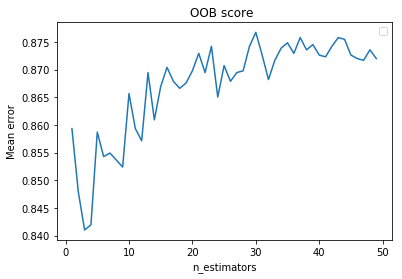

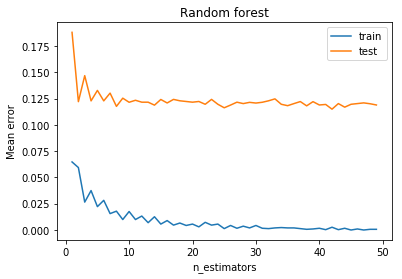

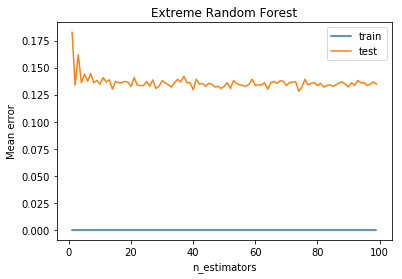

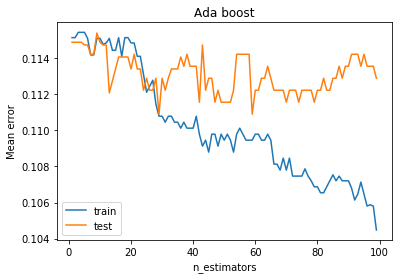

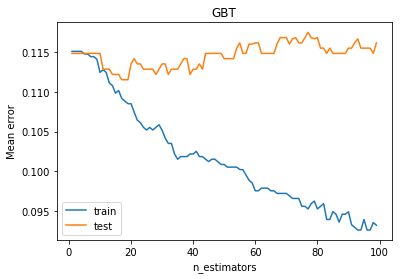

In [74]:
for name, parameters in classifiers.items():
    train_errors, test_errors = train_classifiers(parameters["classifier"], parameters["n_estimators"])
    if name == "Random forest":
        visualize_oob_error(parameters["classifier"], parameters["n_estimators"])
    visualize_error_rate_for_estimators_number(parameters["n_estimators"], train_errors, test_errors, name)